In [1]:
import pandas as pd
import numpy as np
import torch
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import random
from torch.utils.data import TensorDataset, DataLoader

In [2]:
data = pd.read_csv('training.csv')
items_features = pd.read_csv('item_feature.csv')
data.head()

,user_id,item_id,context_feature_id
0,0,28366,2
1,0,16109,2
2,0,11500,3
3,0,20750,2
4,0,8759,2


In [3]:
data.user_id.value_counts().sort_index()

0         6
1         4
2         6
3         4
5         5
         ..
200147    8
200148    4
200149    7
200150    1
200152    5
Name: user_id, Length: 169698, dtype: int64

In [4]:
n = data.shape[0]

# Zero Sampling

In [5]:
data['feedback'] = 1

In [6]:
data.shape

(970245, 4)

In [7]:
def zero_sampling(df_, users_list, item_list, context_list, all_users = False, all_items = False, k=1):
    random.seed(0)
    N = df_.shape[0]
    result_array = []
    for i in range(int(N * k)):
        rand_user = random.choice(users_list)
        rand_item = random.choice(item_list)
        rand_context = random.choice(context_list)
        fake_feedback = 0
        random_gen = (rand_user, rand_item, rand_context, fake_feedback)
        result_array.append(random_gen)
    
    if all_users: 
        for user in users_list:
            rand_item = random.choice(item_list)
            rand_context = random.choice(context_list)
            fake_feedback = 0
            random_gen = (user, rand_item, rand_context, fake_feedback)
            result_array.append(random_gen)
            
    if all_items:
        for item in item_list:
            rand_user = random.choice(users_list)
            rand_context = random.choice(context_list)
            fake_feedback = 0
            random_gen = (rand_user, item, rand_context, fake_feedback)
            result_array.append(random_gen)
    
    zero_df = pd.DataFrame(result_array, columns=['user_id', 'item_id', 'context_feature_id', 'feedback'])
    
    df_with_zeros = pd.concat([df_, zero_df])
    df_with_zeros = df_with_zeros.drop_duplicates(subset=['user_id', 'item_id'], keep='first')
    return df_with_zeros

In [8]:
# unique users items and context
# users = np.sort(data.user_id.unique())
# unique_items = np.sort(data.item_id.unique())
# context = np.sort(data.context_feature_id.unique())

users = np.arange(0, data.user_id.max())
unique_items = np.arange(0, data.item_id.max())
context = np.arange(0,data.context_feature_id.max())

# call zero sampling to get dataframe with zeros
df = zero_sampling(data, users, unique_items, context, all_users=True, all_items=False, k=1.2)

# Train Test Split

In [9]:
# train test split
np.random.seed(0)
mask = np.random.rand(len(df)) < 0.8
train = df[mask].reset_index()
valid = df[~mask].reset_index()

# Matrix Factorization

In [10]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, seed=23):
        super(MF, self).__init__()
        torch.manual_seed(seed)
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.item_bias = nn.Embedding(num_items, 1)
        # init 
        self.user_emb.weight.data.uniform_(0,0.05)
        self.item_emb.weight.data.uniform_(0,0.05)
        self.user_bias.weight.data.uniform_(-0.01,0.01)
        self.item_bias.weight.data.uniform_(-0.01,0.01)

    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        b_i = self.user_bias(u).squeeze()
        c_j = self.item_bias(v).squeeze()
        
        return torch.sigmoid((U * V).sum(1) + b_i + c_j)

In [11]:
num_users = train.user_id.max() + 10
num_items = train.item_id.max() + 10
print(num_users, num_items) 

200162 39910


In [12]:
def valid_loss(model):
    model.eval()
    users = torch.LongTensor(valid.user_id.values) 
    items = torch.LongTensor(valid.item_id.values) 
    feedback = torch.FloatTensor(valid.feedback.values) 
    y_hat = model(users, items)
    loss = F.binary_cross_entropy(y_hat, feedback)
    return loss.item()

In [13]:
# here we are not using data loaders because our data fits well in memory
def train_epocs(model, epochs=10, lr=0.01, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for i in range(epochs):
        model.train()
        users = torch.LongTensor(train.user_id.values)  
        items = torch.LongTensor(train.item_id.values) 
        feedback = torch.FloatTensor(train.feedback.values)  
    
        y_hat = model(users, items)
        
        loss = F.binary_cross_entropy(y_hat, feedback)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        testloss = valid_loss(model)
        print('Epoch Number:', i+1,"train loss %.3f valid loss %.3f" % (loss.item(), testloss)) 

In [14]:
# here we are not using data loaders because our data fits well in memory
def train_epocs_dl(model, epochs=10, lr=0.01, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    train_list = []
    val_list = []
    losses = []
    for i in range(epochs):
        model.train()
        users = torch.LongTensor(train.user_id.values)  
        items = torch.LongTensor(train.item_id.values) 
        feedback = torch.FloatTensor(train.feedback.values) 
        train_dataset = TensorDataset(users, items, feedback)
        train_dl = DataLoader(train_dataset, batch_size=100000, shuffle=True)
        for u, it, f in train_dl:
            y_hat = model(u, it)
            loss = F.binary_cross_entropy(y_hat, f)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            
        train_loss = np.mean(losses)
        testloss = valid_loss(model)
        train_list.append(train_loss)
        val_list.append(testloss)
            
        print('Epoch Number:', i+1,"train loss %.3f valid loss %.3f" % (train_loss, testloss)) 
    return train_list, val_list

In [15]:
model = MF(num_users, num_items, emb_size=50) 

In [16]:
train_score, val_score = train_epocs_dl(model, epochs=10, lr=0.1, wd=0.000001)

Epoch Number: 1 train loss 0.494 valid loss 0.374
Epoch Number: 2 train loss 0.400 valid loss 0.322
Epoch Number: 3 train loss 0.344 valid loss 0.293
Epoch Number: 4 train loss 0.309 valid loss 0.287
Epoch Number: 5 train loss 0.290 valid loss 0.285
Epoch Number: 6 train loss 0.276 valid loss 0.283
Epoch Number: 7 train loss 0.266 valid loss 0.281
Epoch Number: 8 train loss 0.258 valid loss 0.281
Epoch Number: 9 train loss 0.251 valid loss 0.280
Epoch Number: 10 train loss 0.246 valid loss 0.279


In [17]:
train_score, val_score = train_epocs_dl(model, epochs=5, lr=0.01, wd=0.000001)

Epoch Number: 1 train loss 0.177 valid loss 0.283
Epoch Number: 2 train loss 0.173 valid loss 0.281
Epoch Number: 3 train loss 0.170 valid loss 0.278
Epoch Number: 4 train loss 0.168 valid loss 0.277
Epoch Number: 5 train loss 0.166 valid loss 0.276


# Test Model

In [18]:
train = df.copy()
test = pd.read_csv('test_kaggle.csv')
test.head()

,id,user_id,item_id,context_feature_id
0,0,4,16835,2
1,1,4,22590,3
2,2,4,1978,1
3,3,4,28916,1
4,4,4,14427,2


In [19]:
num_users = train.user_id.max() + 1
num_items = train.item_id.max() + 1
print(num_users, num_items) 

200153 39901


In [20]:
model = MF(num_users, num_items, emb_size=50) 

In [21]:
train_score, val_score = train_epocs_dl(model, epochs=10, lr=0.1, wd=0.000001)

Epoch Number: 1 train loss 0.466 valid loss 0.299
Epoch Number: 2 train loss 0.382 valid loss 0.204
Epoch Number: 3 train loss 0.335 valid loss 0.180
Epoch Number: 4 train loss 0.310 valid loss 0.183
Epoch Number: 5 train loss 0.295 valid loss 0.179
Epoch Number: 6 train loss 0.284 valid loss 0.176
Epoch Number: 7 train loss 0.275 valid loss 0.173
Epoch Number: 8 train loss 0.269 valid loss 0.172
Epoch Number: 9 train loss 0.263 valid loss 0.170
Epoch Number: 10 train loss 0.258 valid loss 0.168


In [22]:
train_score, val_score = train_epocs_dl(model, epochs=5, lr=0.01, wd=0.000001)

Epoch Number: 1 train loss 0.191 valid loss 0.178
Epoch Number: 2 train loss 0.187 valid loss 0.175
Epoch Number: 3 train loss 0.185 valid loss 0.171
Epoch Number: 4 train loss 0.183 valid loss 0.168
Epoch Number: 5 train loss 0.181 valid loss 0.166


In [23]:
# get the predictions
test_users = torch.LongTensor(test.user_id.values)
test_items = torch.LongTensor(test.item_id.values)
y_hat = model(test_users, test_items)

In [24]:
# detach to numpy
y_hat = y_hat.detach().numpy()

In [25]:
test['rating'] = y_hat

In [26]:
pred = test['rating']

In [27]:
pred

0         0.451889
1         0.290430
2         0.827812
3         0.153151
4         0.149153
            ...   
381380    0.715378
381381    0.972271
381382    0.927684
381383    0.927684
381384    0.212759
Name: rating, Length: 381385, dtype: float32

In [28]:
pred.to_csv('dataloader_01_001')

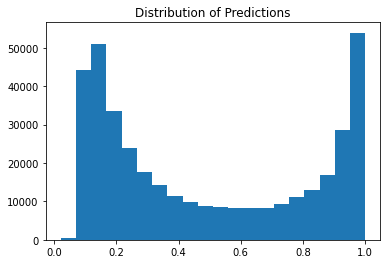

In [29]:
import matplotlib.pyplot as plt
plt.hist(pred, bins = 20)
plt.title('Distribution of Predictions')
plt.show()